Pour rappel, cet examen est à réaliser par groupes d'au plus trois étudiants.

Vous devez télécharger et utiliser les jeux de données suivant : train et test (source : Kaggle).

Les données sont des images représentant les lettres de l'alphabet en langue des signes. Les classes indexées de 0 à 25 représentent les lettres de A à Z. À noter qu'il n'y a pas de données pour les lettres J et Z (car on ne les représente pas par des signes statiques mais par des mouvements).

Vous devrez développer "from scratch" vos propres réseaux de neurones pour résoudre ce problème de classification. Utiliser un modèle pré-entrainé n'est autorisé que dans la question correspondante.

Votre rendu se fera sous la forme d'un archive au format .zip contenant un notebook Jupyter (code source), son export au format PDF (ou HTML) ainsi qu'une sauvegarde de votre modèle final. Tout projet ne comportant pas ces trois éléments sera ajourné sans contestation possible.

Toutes les étapes de votre projet devront être commentées et justifiées. Tous les résultats devront être interprétés. La qualité de la rédaction (style, grammaire et orthographe) sera prise en compte. Un rendu professionnel est attendu.

L'usage de Python et de la librairie Tensorflow est obligatoire.

1. Charger les données et les transformer en images de 28 x 28 pixels.
2. Ce dataset est-il équilibré ? Est-il nécessaire de rééquilibrer les données ? Le faire si besoin est.
3. Construire un réseau de neurones convolutif pour résoudre ce problème de classification. Il devra contenir au minimum les éléments suivants : couches de convolution, couche de "pooling", "dropout", couches cachées complètement connectées. Vous êtes libres d'ajouter d'autres éléments.
4. Entraîner le modèle construit à la question précédente et mesurer sa performance.
5. Faire une recherche de meilleurs hyperparamètres avec la fonction "GridSearchCV“.
6. Utiliser une technique d'augmentation d'images. Les résultats de vos modèles s'en trouvent-ils améliorés ? Était-ce prévisible ?
7. Sauvegarder votre meilleur modèle.
8. Utiliser votre meilleur modèle avec des photos prises pour l'occasion où vous représenterez différents signes.
9. Choisir un des modèles pré-entrainés disponible avec Keras. Le charger et le personnaliser avec des couches de convolution et complètement connectées. L'entraîner et mesurer sa performance. La comparer avec celles de votre meilleur modèle.

#### 1. Charger les données et les transformer en images de 28 x 28 pixels.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Chargement des données
# path= "/content/drive/My Drive/Colab Notebooks/5DEEP/Project"
X_test = pd.read_csv("./Sign MNIST Test.csv")
train_data = pd.read_csv("./Sign MNIST Training Data.csv")

target= "label"

In [3]:
X_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [4]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


#### 2. Ce dataset est-il équilibré ? Est-il nécessaire de rééquilibrer les données ? Le faire si besoin est.

label
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: count, dtype: int64


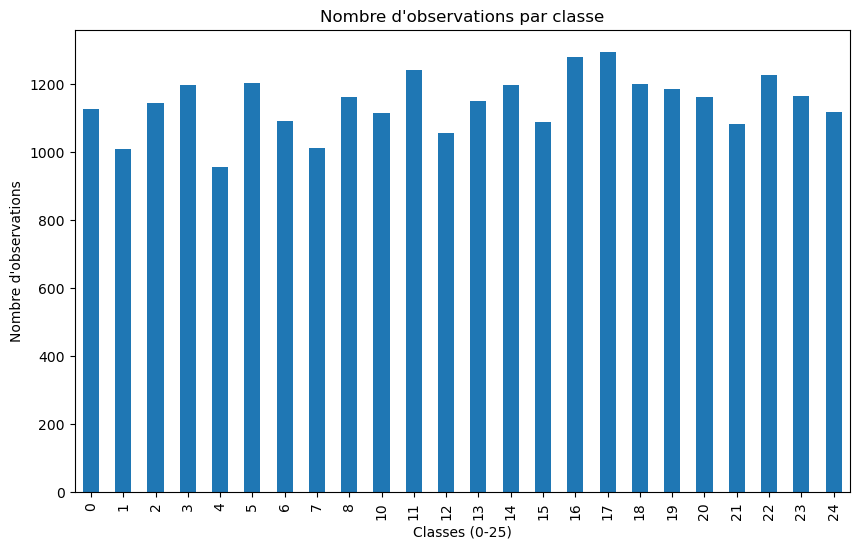

In [5]:
# Compter le nombre d'observations par classe dans la colonne 'label'
label_counts = train_data[target].value_counts().sort_index()

# Afficher le nombre d'observations pour chaque classe
print(label_counts)

# Visualiser les résultats sous forme de graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
label_counts.plot(kind='bar')
plt.title("Nombre d'observations par classe")
plt.xlabel("Classes (0-25)")
plt.ylabel("Nombre d'observations")
plt.show()

Globalement le dataset est équilibré (il ne manque pas énormément de données à l'une des classe par exemple). Vu qu'il y a un set de validation à faire, je vais prendre toutes les valeurs en plus pour en faire le set de validation.

In [6]:
# # Créer à partir de X_train un X_val = redéfinir X_train et définir X_val
# X_train, X_val = train_test_split(X_train, test_size=1/6)

# y_train = X_train[target]
# y_test = X_test[target]
# y_val = X_val[target]

# print("Taille du jeu d'entraînement :", X_train.shape, y_train.shape)
# print("Taille du jeu de validation :", X_val.shape, y_val.shape)
# print("Taille du jeu de test :", X_test.shape, y_test.shape)

label
3     900
6     900
7     900
5     900
0     900
4     900
15    900
11    900
12    900
1     900
24    900
23    900
21    900
19    900
17    900
20    900
10    900
18    900
22    900
8     900
16    900
13    900
2     900
14    900
Name: count, dtype: int64
label
17    394
16    379
11    341
22    325
5     304
18    299
3     296
14    296
19    286
23    264
8     262
20    261
13    251
2     244
0     226
24    218
10    214
6     190
15    188
21    182
12    155
7     113
1     110
4      57
Name: count, dtype: int64


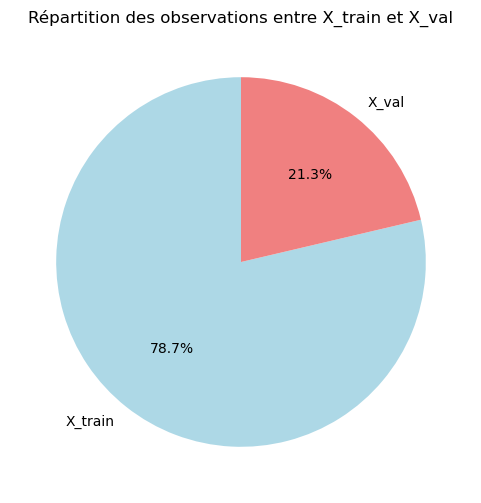

In [7]:
# Equilibrer et créer X_val

nb_obs_by_class = 900

# Initialiser des DataFrames pour les données équilibrées et les excédents
X_train = pd.DataFrame()
X_val = pd.DataFrame()

# Pour chaque classe, équilibrer les données
for label in train_data[target].unique():
    # Filtrer les observations de la classe en question
    class_data = train_data[train_data[target] == label]

    # Mélanger les données de la classe
    class_data = class_data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Prendre 900 observations pour le dataset équilibré
    balanced_class_data = class_data.iloc[:nb_obs_by_class]

    # Mettre les données excédentaires dans X_val
    excess_class_data = class_data.iloc[nb_obs_by_class:]

    # Ajouter au DataFrame global
    X_train = pd.concat([X_train, balanced_class_data], ignore_index=True)
    X_val = pd.concat([X_val, excess_class_data], ignore_index=True)

# Vérifier que le dataset est équilibré
print(X_train[target].value_counts())

# Vérifier les données excédentaires
print(X_val[target].value_counts())

import matplotlib.pyplot as plt

# Compter le nombre total d'observations dans X_train et X_val
train_size = len(X_train)
val_size = len(X_val)

# Créer les labels et les tailles pour le camembert
labels = ['X_train', 'X_val']
sizes = [train_size, val_size]

# Créer le graphique camembert
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])

# Ajouter un titre
plt.title("Répartition des observations entre X_train et X_val")

# Afficher le graphique
plt.show()


In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(21600, 785)
(5855, 785)
(7172, 785)


In [9]:
target="label"

# création des y
y_train = X_train[target]
y_test = X_test[target]
y_val = X_val[target]

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

# création des x
X_train = X_train.drop(columns=[target])
X_test = X_test.drop(columns=[target])
X_val = X_val.drop(columns=[target])

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(21600,)
(7172,)
(5855,)
(21600, 784)
(7172, 784)
(5855, 784)


#### 1. Redimensionner les images en 28*28.

In [10]:
# Redimensionner les images en 28*28

# Taille de l'image
image_w = 28
image_h = 28

# Dictionnaire pour associer les classes à des lettres (0-25 correspond à A-Y, pas de J ni Z)
labels = {
    0 : "A", 1 : "B", 2 : "C", 3 : "D", 4 : "E", 5 : "F",
    6 : "G", 7 : "H", 8 : "I", 9 : "J", 10 : "K", 11 : "L",
    12 : "M", 13 : "N", 14 : "O", 15 : "P", 16 : "Q", 17 : "R",
    18 : "S", 19 : "T", 20 : "U", 21 : "V", 22 : "W", 23 : "X",
    24 : "Y", 25 : "Z"
}

# Redimensionner X_train, X_test, et X_val en 28x28
X_train_image = X_train.to_numpy().reshape(X_train.shape[0], image_w, image_h)
X_test_image = X_test.to_numpy().reshape(X_test.shape[0], image_w, image_h)
X_val_image = X_val.to_numpy().reshape(X_val.shape[0], image_w, image_h)

# Vérification des nouvelles dimensions
print(X_train_image.shape)  # (nombre d'observations, 28, 28)
print(X_test_image.shape)   # (nombre d'observations, 28, 28)
print(X_val_image.shape)    # (nombre d'observations, 28, 28)

(21600, 28, 28)
(7172, 28, 28)
(5855, 28, 28)


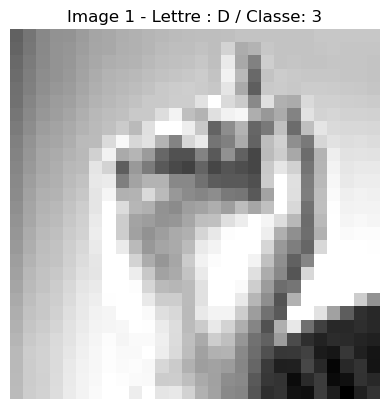

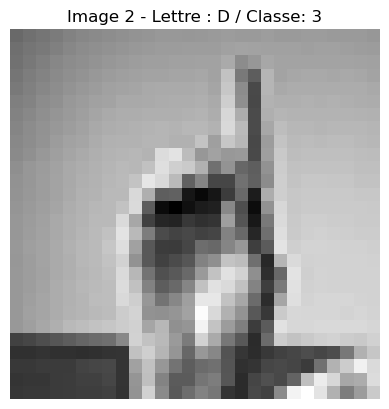

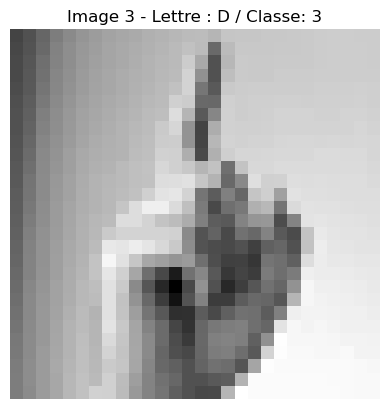

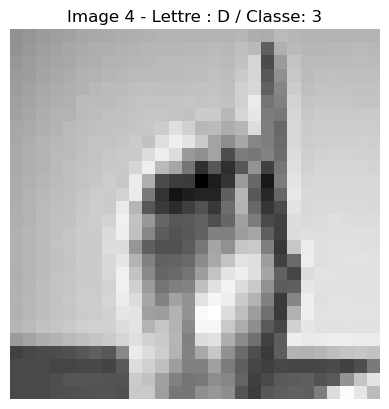

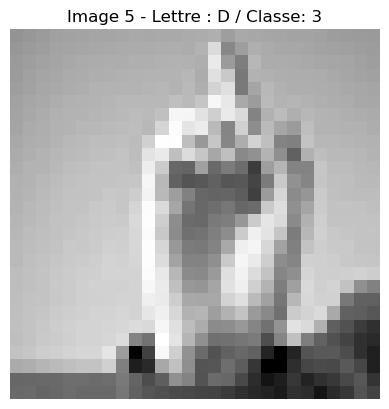

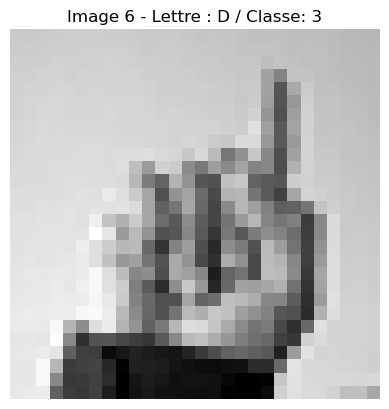

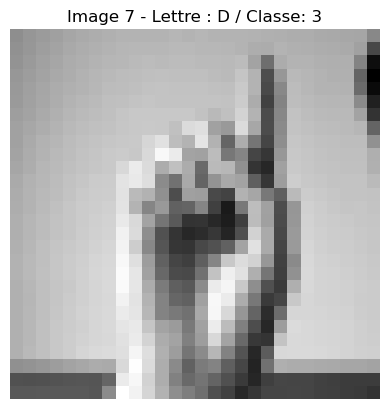

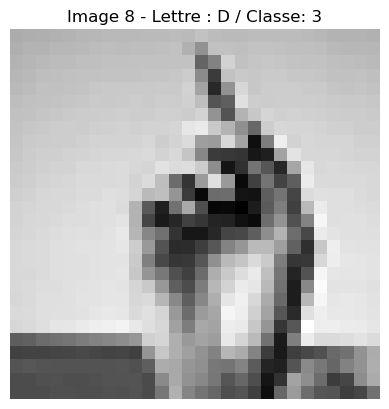

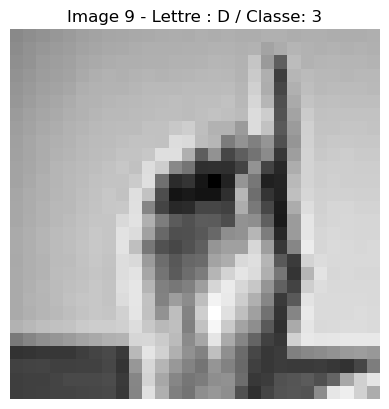

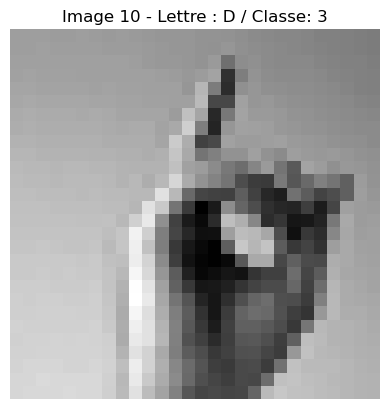

In [11]:
import matplotlib.pyplot as plt

# Afficher les 10 premières images et leurs labels correspondants
for i in range(10):
    # Afficher le label correspondant à l'image (avec iloc pour accéder à l'index correct dans y_train
    label = labels[y_train.iloc[i]]

    # Afficher l'image correspondante
    plt.imshow(X_train_image[i], cmap="gray")
    plt.title(f"Image {i+1} - Lettre : {label} / Classe: {y_train.iloc[i]}")
    plt.axis('off')  # Supprimer les axes pour une meilleure lisibilité
    plt.show()


#### 3. Construire un réseau de neurones convolutif pour résoudre ce problème de classification. Il devra contenir au minimum les éléments suivants : couches de convolution, couche de "pooling", "dropout", couches cachées complètement connectées. Vous êtes libres d'ajouter d'autres éléments.

##### Prétraitement

In [12]:
# Normalisation des données (les pixels sont entre 0 et 255, on les divise par 255 pour les ramener entre 0 et 1)
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0
X_val_norm = X_val / 255.0

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(21600, 784)
(7172, 784)
(5855, 784)


In [13]:
from tensorflow.keras.utils import to_categorical # convertir des labels entiers (catégories) en une représentation one-hot encoding (vecteur de taille n pour le nb de classes, rempli de 0 sauf pour la bonne classe = 1)

y_train_cat = to_categorical(y_train, num_classes=len(labels))
y_val_cat = to_categorical(y_val, num_classes=len(labels))
y_test_cat = to_categorical(y_test, num_classes=len(labels))

input_dim = X_train_norm.shape[1]
output_dim = y_train_cat.shape[1]

print(input_dim) # nb de features
print(output_dim) # nb de target => ici 1 car ojn cherche la lettre

784
26


##### Evaluation des modèles
On crée un dictionnaire performance qui va stocker les scores des différents modèles pour pouvoir les comparer.

In [14]:
import seaborn as sns
from tensorflow.keras.utils import plot_model

def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(15,6))
    hist_data = history.history
    hist_data["epochs"] = list(range(1, len(history.history["loss"])+1))

    hist_data = pd.DataFrame(hist_data)
    sns.lineplot(data=hist_data, x="epochs", y="loss", ax=axes[0], color = "blue")
    sns.lineplot(data=hist_data, x="epochs", y="val_loss", ax=axes[0], color = "orange")

    sns.lineplot(data=hist_data, x="epochs", y="categorical_accuracy", ax=axes[1], color = "blue")
    sns.lineplot(data=hist_data, x="epochs", y="val_categorical_accuracy", ax=axes[1], color = "orange")

def compare_predict_true_labels(y_pred):
    for i in range(10):
        print(f"Classe prédite: {labels[np.argmax(y_pred[i])]}")
        print(f"Classe vraie  : {labels[np.argmax(y_test_cat[i])]}")
        # Utilisation de reshape après conversion en NumPy array
        plt.imshow(X_test_norm.iloc[i].to_numpy().reshape(image_w, image_h), cmap="gray")
        plt.show()

performances = {}
models = {}

def evaluate_model(model, name, history):
    # Convertir X_test_norm en tableau NumPy et reformater
    X_test_norm_np = X_test_norm.to_numpy()

    # Vérifier la forme de X_test_norm et le reformater si nécessaire
    if X_test_norm_np.shape[1] == 784:
        X_test_norm_reshaped = X_test_norm_np.reshape(-1, 28, 28, 1)
    else:
        X_test_norm_reshaped = X_test_norm_np

    # Effectuer les prédictions avec les données correctement formatées
    y_pred = model.predict(X_test_norm_reshaped)

    compare_predict_true_labels(y_pred)

    # Afficher la structure du modèle
    plot_model(
        model,
        show_shapes=True,
        show_layer_activations=True,
        show_trainable=True)

    # Évaluer le modèle avec les données correctement formatées
    loss, categorical_accuracy = model.evaluate(X_test_norm_reshaped, y_test_cat)
    performances[name] = {"Loss" : loss, "Accuracy": categorical_accuracy,  "model": model}

    # Ajouter le modèle à l'objet models
    models[name] = model

    # Tracer l'historique
    plot_history(history)
    print(performances)

##### Création d'un modèle de convolution

In [15]:
X_train_image = X_train_norm.to_numpy().reshape(X_train_norm.shape[0], image_w, image_h, 1)
X_val_image = X_val_norm.to_numpy().reshape(X_val_norm.shape[0], image_w, image_h, 1)
X_test_image = X_test_norm.to_numpy().reshape(X_test_norm.shape[0], image_w, image_h, 1)

print(X_train_image.shape) # shape de tout le dataset (nb ligne, width, heigth, nb canaux)

input_shape = X_train_image.shape[1:]
output_dim = y_train_cat.shape[1]

print(input_shape)
print(y_train_cat.shape)
print(output_dim) # vecteur de 26 composantes => lettre entre 0 et 25

(21600, 28, 28, 1)
(28, 28, 1)
(21600, 26)
26


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

def create_cnn_model():
  model = Sequential()

  model.add(Input(shape=input_shape))

  # Première couche de convolution (32 filtres, 3x3 noyau, activation ReLU)
  model.add(Conv2D(32, (3, 3), activation='relu'))
  # Couche de pooling pour réduire la taille des images (2x2) tout en conservant les informations les plus importantes.
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  # Applatir les sorties des convolutions pour passer aux couches denses
  model.add(Flatten())

  # Couche entièrement connectée (128 neurones, activation ReLU)
  model.add(Dense(128, activation='relu'))
  # Dropout pour éviter l'overfitting: probabilité de 0.5 est appliquée ici pour désactiver aléatoirement 50 % des neurones pendant l'entraînement, ce qui aide à prévenir l'overfitting.
  model.add(Dropout(0.5))
  # Couche de sortie avec 26 neurones (pour 26 classes = 26 lettres de l'alphabet), activation softmax pour la classification multi-classes
  model.add(Dense(26, activation='softmax'))

  model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

  model.summary()

  return model

model_cnn = create_cnn_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,538 (439.60 KB)

 Trainable params: 112,538 (439.60 KB)

 Non-trainable params: 0 (0.00 B)

#### 4. Entraîner le modèle construit à la question précédente et mesurer sa performance.

In [17]:
print(X_train_image.shape)
print(X_val_image.shape)

(21600, 28, 28, 1)
(5855, 28, 28, 1)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

nb_epochs = 10 #! 50 ?

history_cnn = model_cnn.fit(
    X_train_image,
    y_train_cat,
    epochs=nb_epochs,
    validation_data=(X_val_image, y_val_cat),
    callbacks=[EarlyStopping(patience=3)]
)

Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.2008 - loss: 2.6414 - val_categorical_accuracy: 0.8026 - val_loss: 0.6854
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.7659 - loss: 0.6865 - val_categorical_accuracy: 0.9289 - val_loss: 0.2338
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - categorical_accuracy: 0.8862 - loss: 0.3321 - val_categorical_accuracy: 0.9829 - val_loss: 0.0755
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - categorical_accuracy: 0.9411 - loss: 0.1757 - val_categorical_accuracy: 0.9933 - val_loss: 0.0354
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.9672 - loss: 0.1008 - val_categorical_accuracy: 0.9974 - val_loss: 0.0181
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - categorical_accuracy: 0.9808 - loss: 0.0672 - val_categorical_accuracy: 0.9954 - val_loss: 0.0178
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - categorical_accuracy: 0.984

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classe prédite: G
Classe vraie  : G


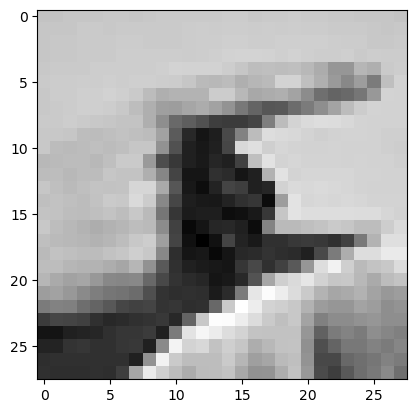

Classe prédite: F
Classe vraie  : F


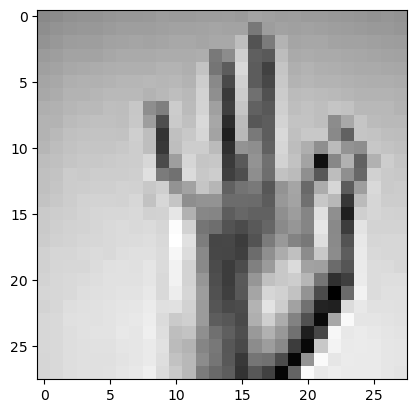

Classe prédite: K
Classe vraie  : K


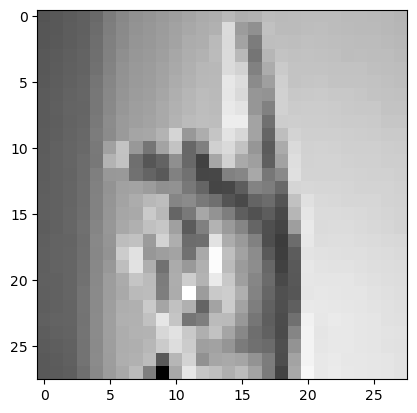

Classe prédite: A
Classe vraie  : A


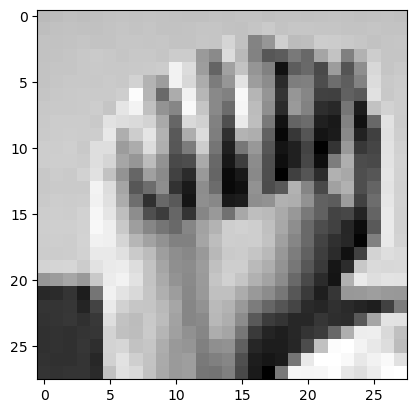

Classe prédite: D
Classe vraie  : D


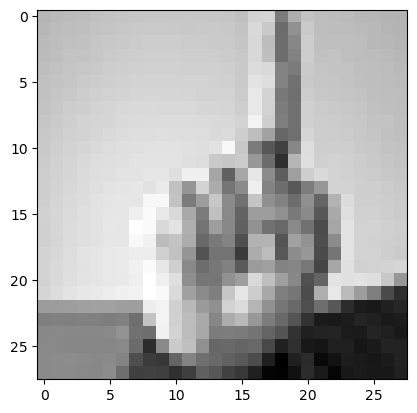

Classe prédite: V
Classe vraie  : V


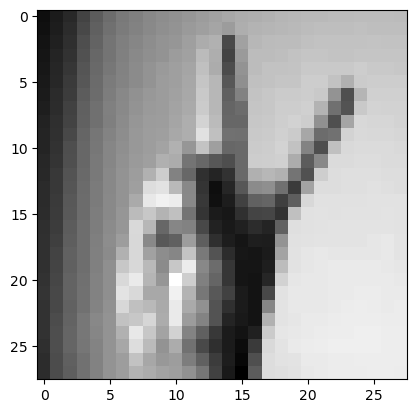

Classe prédite: K
Classe vraie  : K


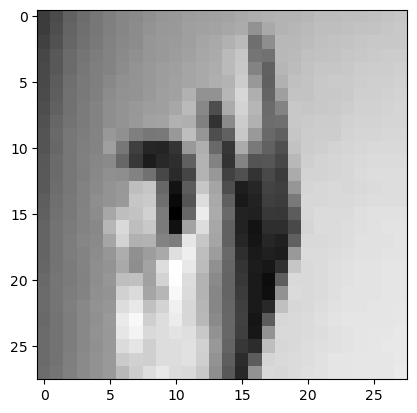

Classe prédite: O
Classe vraie  : O


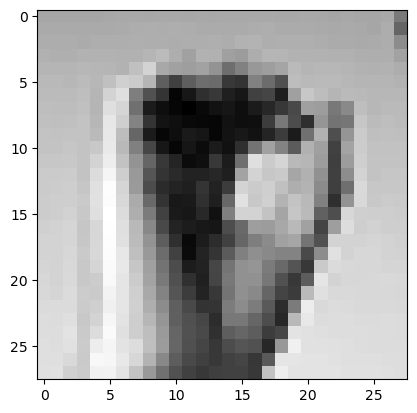

Classe prédite: D
Classe vraie  : D


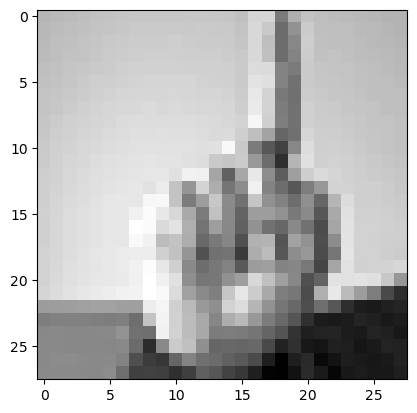

Classe prédite: H
Classe vraie  : H


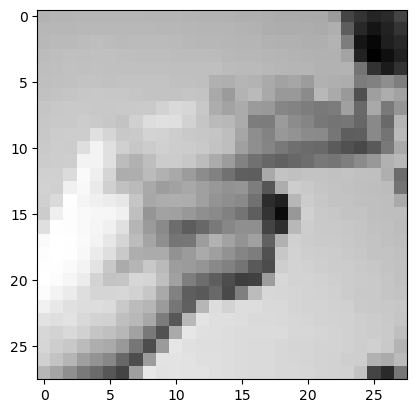

You must install pydot (`pip install pydot`) for `plot_model` to work.
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.9216 - loss: 0.2756
{'CNN': {'Loss': 0.28910189867019653, 'Accuracy': 0.9195482134819031, 'model': <Sequential name=sequential, built=True>}}


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

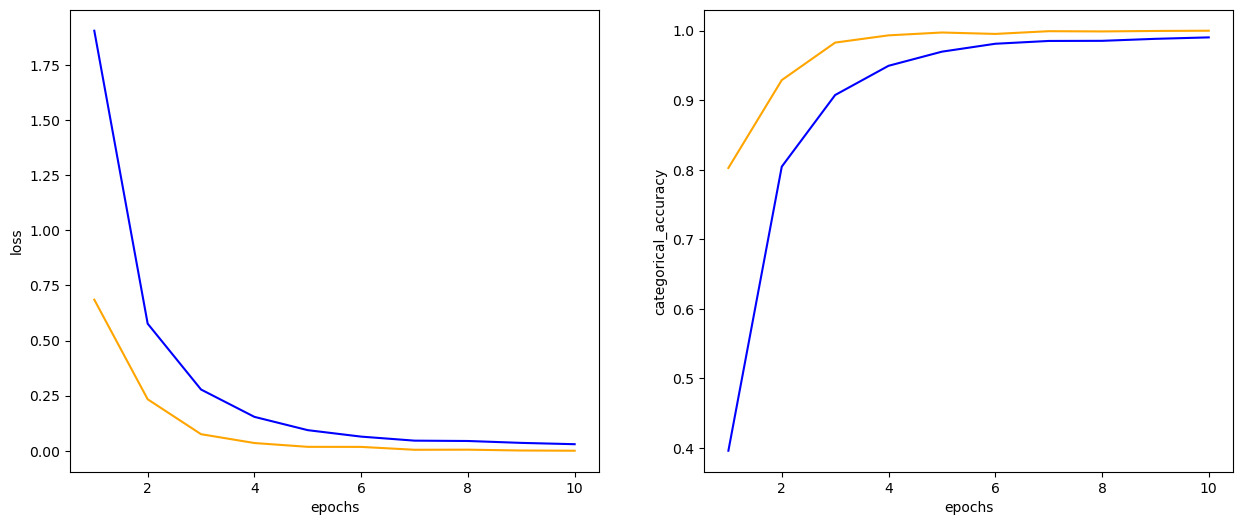

In [19]:
evaluate_model(model_cnn, "CNN", history_cnn)

#### 5. Faire une recherche de meilleurs hyperparamètres avec la fonction "GridSearchCV“.

In [20]:
import sys
print(sys.executable)
!{sys.executable} -m pip install scikeras

/opt/anaconda3/bin/python

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, BackupAndRestore, CSVLogger, Callback
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import os


def create_grid_cnn_model(
    optimizer='adam',
    dropout_rate=0.5,
    neurons=128,
    nb_conv_layers=3,
    alpha=0.01
):
    model = Sequential()

    # Calcul du nombre de filtres en double-entonnoir
    # ex: pour nb_conv_layers=3 : [8, 16, 8] // pour nb_conv_layers = 6: [8, 16, 32, 64, 32, 16]
    # if nb_conv_layers % 2 == 0:
    #     filter_sizes = [2**(3+i) for i in range(nb_conv_layers//2)] + \
    #                    [2**(3+i) for i in range(nb_conv_layers//2-1, -1, -1)]
    # else:
    #     filter_sizes = [2**(3+i) for i in range((nb_conv_layers+1)//2)] + \
    #                    [2**(3+i) for i in range((nb_conv_layers-1)//2-1, -1, -1)]

    # Boucle pour ajouter les couches de convolution et de pooling
    model.add(Input(shape=(28, 28, 1)))
    for i in range(nb_conv_layers):
        model.add(Conv2D(8, (3, 3), activation='relu'))
        # model.add(Conv2D(filter_sizes[i], (3, 3), activation='relu'))
    
    model.add(MaxPooling2D((2, 2)))

    # Couches denses
    model.add(Flatten())
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(26, activation='softmax'))  # 26 classes pour la sortie

    # Configuration de l'optimiseur avec le taux d'apprentissage (alpha)
    if optimizer == 'adam':
        opt = Adam(learning_rate=alpha)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=alpha)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=alpha, momentum=0.1)

    # Compilation du modèle
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

try_model = create_grid_cnn_model(nb_conv_layers=5)
try_model.summary()
history = try_model.fit(X_train_image, y_train_cat, validation_data=(X_val_image, y_val_cat), epochs=3)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 22, 22, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 648)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        83,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,842 (347.04 KB)

 Trainable params: 88,842 (347.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - categorical_accuracy: 0.0389 - loss: 3.2107 - val_categorical_accuracy: 0.0519 - val_loss: 3.1853
Epoch 2/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - categorical_accuracy: 0.0399 - loss: 3.1842 - val_categorical_accuracy: 0.0451 - val_loss: 3.1859
Epoch 3/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - categorical_accuracy: 0.0392 - loss: 3.1827 - val_categorical_accuracy: 0.0555 - val_loss: 3.1792


In [22]:
history.history

{'categorical_accuracy': [0.039351850748062134,
  0.04037037119269371,
  0.03958333283662796],
 'loss': [3.1942734718322754, 3.1842052936553955, 3.182415723800659],
 'val_categorical_accuracy': [0.051921434700489044,
  0.04508966580033302,
  0.05550811439752579],
 'val_loss': [3.1853110790252686, 3.185856342315674, 3.1791844367980957]}

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

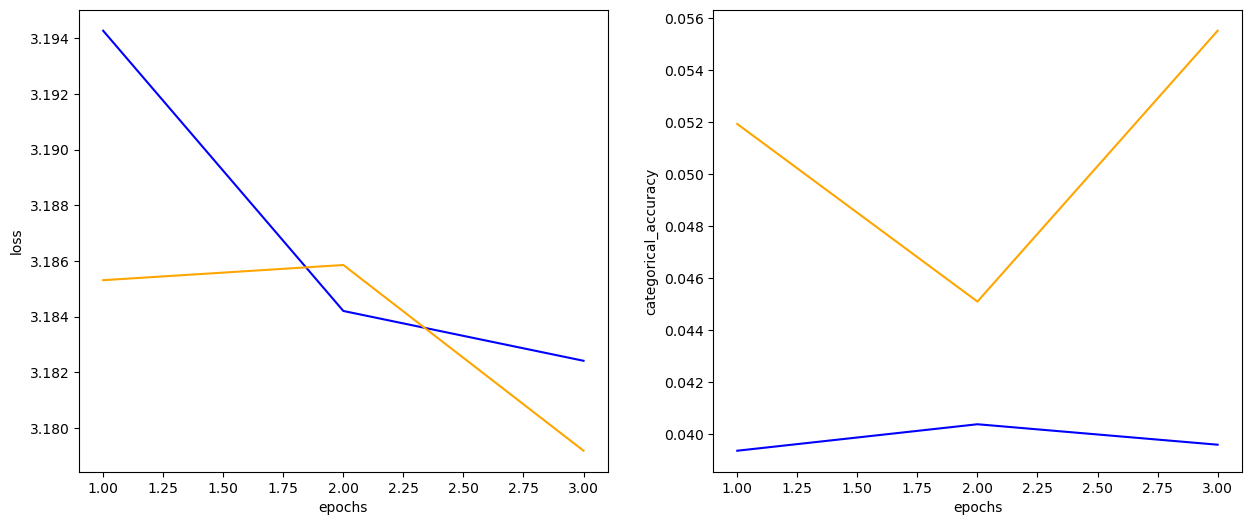

In [23]:
plot_history(history)

In [77]:
callbacks=[
    EarlyStopping(patience=3),
    ModelCheckpoint(filepath='best_model_grid.keras', save_best_only=True)
    ]


# Encapsuler le modèle Keras dans un KerasClassifier pour GridSearchCV
model = KerasClassifier(
    model=create_grid_cnn_model,
    verbose=1,
    # callbacks= [BackupAndRestore(backup_dir="./path_to_backup_dir", save_freq=1)]
)

# Définir la grille des hyperparamètres à explorer
param_grid = {
    'model__nb_conv_layers': [1, 3, 5],
    'model__alpha': [0.001, 0.01, 0.1],
    'model__dropout_rate': [0.3, 0.5, 0.7],
    'model__neurons': [32, 64, 128],
    'model__optimizer': ['adam'],
    'model__optimizer': ['adam', 'rmsprop', 'sgd'],
    'batch_size': [32, 64],
    'epochs': [5, 10]
}

# Initialiser GridSearchCV
grid_cnn_model = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=1,
    cv=3,
    verbose=4,  
    error_score='raise'
)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - categorical_accuracy: 0.4603 - loss: 1.6889
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
[CV 1/3] END model__nb_conv_layers=1, model__optimizer=adam;, score=0.000 total time=   5.2s
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.4761 - loss: 1.6614
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
[CV 2/3] END model__nb_conv_layers=1, model__optimizer=adam;, score=0.000 total time=   4.7s
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.3892 - loss: 1.9270
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
[CV 3/3] END model__nb_conv_layers=1, model__optimizer=adam;, score=0.000 total time=   4.9s
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - categorical_accuracy: 0.3496 - loss: 2.0700
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/3] END model__nb_conv_layers=3, model__optimizer=adam;, score=0.000 total time=   7.4s
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - catego

KeyboardInterrupt: 

In [ ]:
# Lancer la recherche d'hyperparamètres avec GridSearchCV
try:
    grid_cnn_history = grid_cnn_model.fit(X_train_image, y_train_cat, callbacks=callbacks)
except Exception as e:
    print(f"Exécution interrompue : {e}")

# Afficher les meilleurs paramètres et le score associé
print(f"Meilleurs paramètres trouvés : {grid_cnn_model.best_params_}")
print(f"Meilleur score : {grid_cnn_model.best_score_}")

In [38]:
best_cnn_model = grid_cnn_model.best_estimator_
best_cnn_model


KerasClassifier(
	model=<function create_grid_cnn_model at 0x3201771a0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
	model__nb_conv_layers=1
	model__optimizer=adam
)

In [61]:
def evaluate_model(model, name, history):
    # Convertir X_test_norm en tableau NumPy et reformater
    X_test_norm_np = X_test_norm.to_numpy()

    # Vérifier la forme de X_test_norm et le reformater si nécessaire
    if X_test_norm_np.shape[1] == 784:
        X_test_norm_reshaped = X_test_norm_np.reshape(-1, 28, 28, 1)
    else:
        X_test_norm_reshaped = X_test_norm_np

    # Effectuer les prédictions avec les données correctement formatées
    y_pred = model.predict(X_test_norm_reshaped)

    # compare_predict_true_labels(y_pred)

    # # Afficher la structure du modèle
    # plot_model(
    #     model,
    #     show_shapes=True,
    #     show_layer_activations=True,
    #     show_trainable=True)

    # Évaluer le modèle avec les données correctement formatées
    print(X_test_norm_reshaped.shape)
    print(y_test_cat.shape)

     # Vérifier si le modèle est encapsulé par KerasClassifier
    if hasattr(model, 'model_'):
        # Si le modèle est encapsulé dans KerasClassifier, utiliser model_.evaluate()
        loss, categorical_accuracy = model.model_.evaluate(X_test_norm_reshaped, y_test_cat, verbose=0)
    else:
        # Sinon, c'est un modèle Keras direct, utiliser directement evaluate()
        loss, categorical_accuracy = model.evaluate(X_test_norm_reshaped, y_test_cat, verbose=0)

    performances[name] = {"Loss" : loss, "Accuracy": categorical_accuracy,  "model": model}

    # Ajouter le modèle à l'objet models
    models[name] = model

    # Tracer l'historique
    # plot_history(history)
    print(performances)

evaluate_model(best_cnn_model, "grid", grid_cnn_history)

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(7172, 28, 28, 1)
(7172, 26)
{'CNN': {'Loss': 0.28910189867019653, 'Accuracy': 0.9195482134819031, 'model': <Sequential name=sequential, built=True>}, 'grid': {'Loss': 0.9670982956886292, 'Accuracy': 0.6848856806755066, 'model': KerasClassifier(
	model=<function create_grid_cnn_model at 0x3201771a0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
	model__nb_conv_layers=1
	model__optimizer=adam
)}}


#### 6. Utiliser une technique d'augmentation d'images. Les résultats de vos modèles s'en trouvent-ils améliorés ? Était-ce prévisible ?

In [62]:
# from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, AveragePooling2D

# def create_cnn_model_augmentation(input_shape=(28, 28, 1), output_dim=26, optimizer='adam', alpha=0.01):
#     model = Sequential()

#     # Couche d'entrée avec transformations
#     model.add(Input(shape=input_shape))

#     # Transformation appliquée à chaque itération
#     model.add(RandomFlip("horizontal"))
#     model.add(RandomRotation(0.05))
#     model.add(RandomZoom(height_factor=0.2))
#     model.add(RandomTranslation(height_factor=0.1, width_factor=0.1))

#     # Réseau de neurones convolutionnels
#     model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
#     model.add(AveragePooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
#     model.add(AveragePooling2D(pool_size=(2, 2)))

#     # Applatissement des images convoluées
#     model.add(Flatten())

#     # Couches denses pour la classification
#     model.add(Dense(128, activation="relu"))
#     model.add(Dense(output_dim, activation="softmax"))

#     # Compilation du modèle avec optimiseur
#     if optimizer == 'adam':
#         opt = Adam(learning_rate=alpha)
#     elif optimizer == 'rmsprop':
#         opt = RMSprop(learning_rate=alpha)
#     elif optimizer == 'sgd':
#         opt = SGD(learning_rate=alpha, momentum=0.1)

#     model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["categorical_accuracy"])

#     return model


In [63]:
# # Récupérer les meilleurs paramètres trouvés par GridSearchCV
# best_params = grid_cnn_model.best_params_
# print(best_params)

# # Créer un nouveau modèle avec augmentation d'images, en utilisant les meilleurs paramètres
# model_cnn_aug = create_cnn_model_augmentation(
#     input_shape=(28, 28, 1),  # même shape que les datas
#     output_dim=26,  # nombre de classes
#     optimizer=best_params['model__optimizer'],
#     # alpha=best_params['model__alpha']
# )

# # Entraîner le modèle avec augmentation d'images
# history_cnn_aug = model_cnn_aug.fit(
#     X_train_image,  # les données d'entraînement
#     y_train_cat,  # les labels d'entraînement
#     epochs=best_params.get('epochs', 10),  # utiliser le nombre d'epochs trouvé, ou 10 par défaut
#     batch_size=best_params.get('batch_size', 32),  # taille de batch, 32 par défaut
#     validation_data=(X_val_image, y_val_cat),  # données de validation
#     callbacks=[EarlyStopping(patience=3)]
# )

# # Évaluer le modèle après l'augmentation
# evaluate_model(
#     model=model_cnn_aug,
#     name="Réseau convolution (CNN) avec augmentation",
#     history=history_cnn_aug
# )


{'model__nb_conv_layers': 1, 'model__optimizer': 'adam'}
Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.0431 - loss: 3.2019 - val_categorical_accuracy: 0.0511 - val_loss: 3.1768
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - categorical_accuracy: 0.0454 - loss: 3.1813 - val_categorical_accuracy: 0.1428 - val_loss: 2.8426
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - categorical_accuracy: 0.1857 - loss: 2.6045 - val_categorical_accuracy: 0.4032 - val_loss: 1.8326
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - categorical_accuracy: 0.3189 - loss: 2.1643 - val_categorical_accuracy: 0.4832 - val_loss: 1.5944
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - categorical_accuracy: 0.3455 - loss: 2.0448 - val_categorical_accuracy: 0.5196 - val_loss: 1.4977
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - categorical_accuracy: 0.3719 - loss: 1.9466 - val_categorical_accuracy: 0.5250 - val_loss: 1.4384
Epoch 7/10
675/675 ━━━━━━━━━━━

In [64]:
# performances

{'CNN': {'Loss': 0.28910189867019653,
  'Accuracy': 0.9195482134819031,
  'model': <Sequential name=sequential, built=True>},
 'grid': {'Loss': 0.9670982956886292,
  'Accuracy': 0.6848856806755066,
  'model': KerasClassifier(
  	model=<function create_grid_cnn_model at 0x3201771a0>
  	build_fn=None
  	warm_start=False
  	random_state=None
  	optimizer=rmsprop
  	loss=None
  	metrics=None
  	batch_size=None
  	validation_batch_size=None
  	verbose=1
  	callbacks=None
  	validation_split=0.0
  	shuffle=True
  	run_eagerly=False
  	epochs=1
  	class_weight=None
  	model__nb_conv_layers=1
  	model__optimizer=adam
  )},
 'Réseau convolution (CNN) avec augmentation': {'Loss': 1.4390403032302856,
  'Accuracy': 0.5231455564498901,
  'model': <Sequential name=sequential_24, built=True>}}

Le modèle 'CNN' est le meilleur :
- Loss (perte) : Le modèle 'CNN' a la plus faible perte (0.2891), ce qui signifie que la différence entre les prédictions du modèle et les vraies valeurs est la plus faible. En général, une perte plus faible indique un meilleur ajustement du modèle aux données.

- Accuracy (exactitude) : Le modèle 'CNN' a l'exactitude la plus élevée, à 91.95%, ce qui signifie qu'il fait le moins d'erreurs dans la classification par rapport aux autres modèles.

- Comparaison avec 'grid' et 'Réseau convolution (CNN) avec augmentation' :
    - Le modèle 'grid' a une perte plus élevée (0.9671) et une exactitude plus faible (68.49%). Cela signifie que malgré l'optimisation des hyperparamètres via GridSearchCV, ce modèle n'est pas aussi performant que le modèle 'CNN'.
    - Le modèle 'Réseau convolution (CNN) avec augmentation' a la perte la plus élevée (1.4390) et l'exactitude la plus faible (52.31%), ce qui indique qu'il a le plus de difficulté à prédire correctement les classes.

#### 7. Sauvegarder votre meilleur modèle.

In [66]:
# import os

# def save_best_model(performances, models, save_dir="saved_models"):
#     # Créer un répertoire pour sauvegarder les modèles si nécessaire
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)

#     # Trouver le modèle avec la meilleure exactitude
#     best_model_name = None
#     best_accuracy = 0

#     for name, stats in performances.items():
#         if stats["Accuracy"] > best_accuracy:
#             best_accuracy = stats["Accuracy"]
#             best_model_name = name

#     # Si un modèle avec la meilleure exactitude a été trouvé, le sauvegarder
#     if best_model_name:
#         best_model = models[best_model_name]  # Récupérer le modèle dans l'objet models
#         best_model_path = os.path.join(save_dir, f"best_model.keras")
#         best_model.save(best_model_path)
#         print(f"Meilleur modèle '{best_model_name}' sauvegardé à l'emplacement: {best_model_path}")
#     else:
#         print("Aucun modèle à sauvegarder.")

# # Sauvegarder le modèle avec les meilleures performances
# save_best_model(performances, models)


Meilleur modèle 'CNN' sauvegardé à l'emplacement: saved_models/best_model.keras


#### 8. Utiliser votre meilleur modèle avec des photos prises pour l'occasion où vous représenterez différents signes.

In [ ]:
# from PIL import Image
# import numpy as np
# import os

# # Préparer et charger les nouvelles images
# def load_and_preprocess_image(image_path, target_size=(28, 28)):
#     # Charger l'image
#     img = Image.open(image_path).convert('L')  # Convertir en niveaux de gris

#     # Redimensionner l'image à la taille souhaitée
#     img = img.resize(target_size)

#     # Convertir l'image en tableau NumPy
#     img_array = np.array(img)

#     # Normaliser l'image (les valeurs de pixels entre 0 et 1)
#     img_array = img_array / 255.0

#     # Reshaper pour correspondre à l'entrée du modèle (28, 28, 1)
#     img_array = img_array.reshape(1, 28, 28, 1)

#     return img_array

# # Charger le meilleur modèle sauvegardé
# from tensorflow.keras.models import load_model

# best_model_path = 'saved_models/best_model.keras'
# best_model = load_model(best_model_path)

# # Charger et prétraiter les images persos (ajouter ici les chemins vers les images)
# image_paths = ['path_to_image_1.jpg', 'path_to_image_2.jpg', 'path_to_image_3.jpg']

# # Faire des prédictions sur chaque image
# for image_path in image_paths:
#     img_array = load_and_preprocess_image(image_path)

#     # Faire la prédiction avec le modèle chargé
#     y_pred = best_model.predict(img_array)

#     # Afficher le résultat de la prédiction
#     predicted_class = np.argmax(y_pred)
#     predicted_label = labels[predicted_class]

#     print(f"Image: {image_path}, Prédiction: {predicted_label}")


####9. Choisir un des modèles pré-entrainés disponible avec Keras. Le charger et le personnaliser avec des couches de convolution et complètement connectées. L'entraîner et mesurer sa performance. La comparer avec celles de votre meilleur modèle.

In [ ]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Input
# from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# # Charger le modèle VGG16 pré-entraîné sur ImageNet sans les couches de classification
# vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(28, 28, 3))

In [ ]:
# # Congeler les couches de base pour éviter de réentraîner les poids
# for layer in vgg_base.layers:
#     layer.trainable = False

# def create_custom_model_vgg16():
#     model = Sequential()

#     # Ajouter le modèle VGG16 pré-entraîné comme base
#     model.add(vgg_base)

#     # Ajouter des couches de convolution supplémentaires
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(Dropout(0.5))

#     # Aplatir les sorties des convolutions
#     model.add(Flatten())

#     # Ajouter des couches complètement connectées
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(26, activation='softmax'))  # 26 classes pour la sortie

#     # Compiler le modèle
#     model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#     return model

# # Créer le modèle personnalisé
# custom_model_vgg16 = create_custom_model_vgg16()

# # Entraîner le modèle
# history_custom_vgg16 = custom_model_vgg16.fit(
#     X_train_image,  # Images d'entraînement
#     y_train_cat,  # Labels d'entraînement
#     epochs=10,  # Nombre d'epochs
#     batch_size=32,  # Taille du batch
#     validation_data=(X_val_image, y_val_cat),  # Données de validation
#     callbacks=[EarlyStopping(patience=3)]  # Early stopping si l'entraînement stagne
# )

In [ ]:
# # Évaluer le modèle avec les images de test
# evaluate_model(custom_model_vgg16, "VGG16 personnalisé", history_custom_vgg16)


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.optimizers import Adam, RMSprop, SGD
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, BackupAndRestore
# from scikeras.wrappers import KerasClassifier
# from sklearn.model_selection import GridSearchCV
# import os

# def create_grid_cnn_model(
#     optimizer='adam',
#     dropout_rate=0.5,
#     neurons=128,
#     nb_conv_layers=3,
#     alpha=0.01
# ):
#     model = Sequential()

#     # Calcul du nombre de filtres en double-entonnoir
#     if nb_conv_layers % 2 == 0:
#         filter_sizes = [2**(3+i) for i in range(nb_conv_layers//2)] + \
#                        [2**(3+i) for i in range(nb_conv_layers//2-1, -1, -1)]
#     else:
#         filter_sizes = [2**(3+i) for i in range((nb_conv_layers+1)//2)] + \
#                        [2**(3+i) for i in range((nb_conv_layers-1)//2-1, -1, -1)]

#     for i in range(nb_conv_layers):
#         if i == 0:
#             model.add(Conv2D(filter_sizes[i], (3, 3), activation='relu', input_shape=(28, 28, 1)))
#         else:
#             model.add(Conv2D(filter_sizes[i], (3, 3), activation='relu'))
#         model.add(MaxPooling2D((2, 2)))

#     model.add(Flatten())
#     model.add(Dense(neurons, activation='relu'))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(26, activation='softmax'))

#     if optimizer == 'adam':
#         opt = Adam(learning_rate=alpha)
#     elif optimizer == 'rmsprop':
#         opt = RMSprop(learning_rate=alpha)
#     elif optimizer == 'sgd':
#         opt = SGD(learning_rate=alpha, momentum=0.1)

#     model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#     return model

# # Crée une fonction pour sauvegarder les états intermédiaires des modèles
# backup_dir = '/path_to_backup_dir'
# os.makedirs(backup_dir, exist_ok=True)

# # KerasClassifier
# model = KerasClassifier(
#     model=create_grid_cnn_model,
#     verbose=1,
#     callbacks=[
#         EarlyStopping(monitor='val_loss', patience=3),
#         ModelCheckpoint(filepath='best_model_grid.keras', save_best_only=True),
#         BackupAndRestore(backup_dir=backup_dir, save_freq="epoch")
#     ]
# )

# # Grille des hyperparamètres
# param_grid = {
#     'model__nb_conv_layers': [1, 3, 5],
#     'model__alpha': [0.001, 0.01, 0.1],
#     'model__dropout_rate': [0.3, 0.5, 0.7],
#     'model__neurons': [32, 64, 128],
#     'optimizer': ['adam', 'rmsprop', 'sgd'],
#     'batch_size': [32, 64],
#     'epochs': [5, 10]
# }

# # GridSearchCV
# grid_cnn_model = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     n_jobs=-1,
#     cv=3,
#     verbose=2
# )

# # Lancement de la recherche
# grid_cnn_history = grid_cnn_model.fit(X_train_image, y_train_cat)

# # Affichage des meilleurs paramètres et du score
# print(f"Meilleurs paramètres trouvés : {grid_cnn_model.best_params_}")
# print(f"Meilleur score : {grid_cnn_model.best_score_}")


In [ ]:
# import json

# # Chemin vers le fichier pour stocker les hyperparamètres testés
# param_log_file = 'grid_search_log.json'

# # Fonction pour charger les hyperparamètres testés
# def load_tested_params(log_file):
#     if os.path.exists(log_file):
#         with open(log_file, 'r') as f:
#             return json.load(f)
#     return []

# # Fonction pour sauvegarder les hyperparamètres testés
# def save_tested_params(log_file, params):
#     with open(log_file, 'w') as f:
#         json.dump(params, f)

# # Charger les hyperparamètres déjà testés
# tested_params = load_tested_params(param_log_file)

# # Boucle pour GridSearchCV (en remplaçant la recherche d'hyperparamètres normale)
# for params in param_grid:
#     if params not in tested_params:
#         try:
#             # Effectuer l'entraînement et la validation avec ce set d'hyperparamètres
#             grid_cnn_model.set_params(**params)
#             grid_cnn_model.fit(X_train_image, y_train_cat)
            
#             # Si succès, ajouter ces hyperparamètres aux log
#             tested_params.append(params)
#             save_tested_params(param_log_file, tested_params)
#         except Exception as e:
#             print(f"Erreur avec les paramètres {params}: {e}")
